In [1]:
import copy


In [393]:
if __name__ == '__main__':   
    %run Tests.ipynb
    %run MoleculeGenerator2.ipynb
    %run Discrim.ipynb
    %run Rewards.ipynb
    %run PPO_WITH_TRICKS.ipynb
    %run ChemEnv.ipynb
    %run SupervisedPreTraining.ipynb

In [388]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [389]:
# wants: a single class for pretraining and rl training
#     also want a singler logger for everything
#     also should put in cross validation for the supervised portion
#     means a logger instance in the init method

class SupervisedToReinforcement():
    def __init__(self,run_title, rewards_list, chem_env_kwargs, PPO_kwargs, svw_kwargs):
        
        self.run_title = run_title
        self.writer = SummaryWriter(f'./tb_logs/{run_title}/{run_title}_logs')
        
        self.reward_module =  FinalRewardModule(self.writer,rewards_list)
        
        chem_env_kwargs['num_chunks'] = train_kwargs['num_chunks']
        chem_env_kwargs['RewardModule'] = self.reward_module
        chem_env_kwargs['writer'] = self.writer
        
        self.ChemEnv = ChemEnv(**chem_env_kwargs)
        
        
        input_dim = chem_env_kwargs['num_node_feats']
        
        #self.policy = Spin2(input_dim,300,chem_env_kwargs['num_atom_types']).cuda()
        self.policy = BaseLine(input_dim,800,chem_env_kwargs['num_atom_types']+1).cuda()
        self.policy.apply(init_weights_recursive)
        
        
        
        svw_kwargs['writer'] = self.writer
        svw_kwargs['input_dim'] = input_dim
        svw_kwargs['num_atom_types'] = chem_env_kwargs['num_atom_types']
        
        print(svw_kwargs)
        self.svw = Supervised_Trainer(self.policy, **svw_kwargs)
        
        PPO_kwargs['env'] = self.ChemEnv
        PPO_kwargs['actor'] = self.policy
        PPO_kwargs['writer'] = self.writer
        self.PPO = PPO_MAIN(**PPO_kwargs)
        self.PPO.to_device(device)
        
    
    def Train(self,total_epochs, batch_size, epochs_per_chunk, num_chunks, PPO_steps, cv_path):
        
        self.svw.TrainModel(total_epochs)
    
#         torch.save({
#             'model_state_dict': self.policy.state_dict(),
#             'optimizer_state_dict': self.svw.optim.state_dict()
#             }, f'./{self.run_title}/SavedModel')
        
        print("fra")
#         self.PPO.learn(PPO_steps)
        

In [390]:
%run SupervisedPreTraining.ipynb

In [392]:
# rewards_list = [SizeSynth_norm()]
# rewards_list = [Synthesizability(), SizeReward()]
rewards_list = [ Synthesizability()]

chem_env_kwargs = {'max_nodes' : 12, 
                   'num_atom_types' : 17, 
                   'num_node_feats' : 54,
                   'num_edge_types' : 3, 
                   'bond_padding' : 12, 
                   'mol_featurizer': mol_to_graph_full, 
                   'RewardModule' : None, 
                   'writer' : None}


PPO_kwargs = {'env' : None,
              'batch_size' : 32,
              'timesteps_per_batch' : 1200,
              'clip' : 0.08,
              'a_lr' : 1e-4,
              'c_lr' : 3e-4,
              'n_updates_per_iteration' : 6,
              'max_timesteps_per_episode' : 40,
              'gamma' : .95,
              'actor' : None}
svw_kwargs = {'batch_size' : 128, 'data_set_size' : 507528}
train_kwargs = {'total_epochs' : 15,
                'batch_size' : 256,
                'epochs_per_chunk' : 1,
                'num_chunks' : 0,
                'cv_path' : './CrossVal/chunk_11',
                'PPO_steps' : 150000}


%run ChemEnv.ipynb
svtr = SupervisedToReinforcement('test_18',rewards_list,chem_env_kwargs,PPO_kwargs,svw_kwargs)
svtr.Train(**train_kwargs)



{'batch_size': 128, 'data_set_size': 507528, 'writer': <torch.utils.tensorboard.writer.SummaryWriter object at 0x7f18035f9210>, 'input_dim': 54, 'num_atom_types': 17}
507528
correcto
Time for epoch 0 is 511.0425159931183, random accuracy is 0.0234375
Time for epoch 1 is 372.5785608291626, random accuracy is 0.5390625
Time for epoch 2 is 371.0341217517853, random accuracy is 0.5859375
Time for epoch 3 is 370.72069692611694, random accuracy is 0.640625
Time for epoch 4 is 367.9514820575714, random accuracy is 0.5390625
Time for epoch 5 is 365.5165026187897, random accuracy is 0.4453125
Time for epoch 6 is 358.8044502735138, random accuracy is 0.484375
Time for epoch 7 is 357.86900663375854, random accuracy is 0.5703125
Time for epoch 8 is 360.4918885231018, random accuracy is 0.5859375
Time for epoch 9 is 358.5659158229828, random accuracy is 0.609375
Time for epoch 10 is 361.24948596954346, random accuracy is 0.5390625
Time for epoch 11 is 361.11463260650635, random accuracy is 0.507812

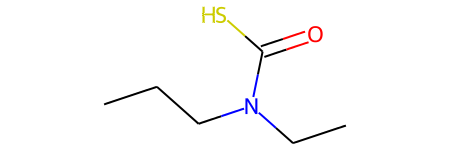

In [376]:
Chem.MolFromSmiles('CCCN(CC)C(=O)S')

CN1CC2CC1CN2.O
[24]
[35]
[34]
[27]
[21]
[19]
[20]
[13]
[27]
[11]
[28]
[35]
[25]
[1]
[32]
[21]
[14]
[45]
[44]
[47]
[24]
[22]
[52]
[18]
[38]
[28]
[33]
[49]
[30]
[51]
[36]
[49]
[31]
[27]
[17]
[39]
[7]
[20]
[28]
[33]


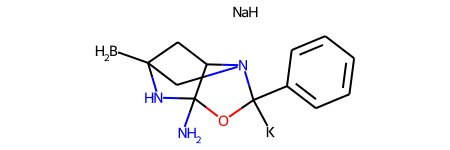

In [386]:
svtr.PPO.inference()

In [385]:
env = svtr.ChemEnv

tensor([[0.]], device='cuda:0')


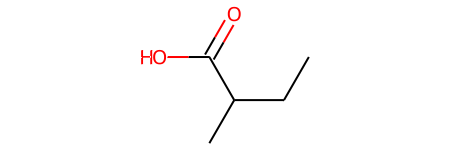

In [345]:
env.assignMol(Chem.MolFromSmiles('CCC(C)C(=O)O'))
print(env.last_action_node)
env.StateSpace

terminating 



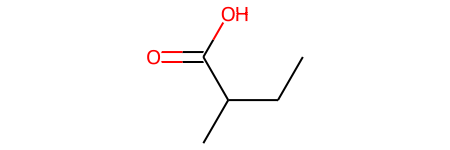

In [310]:
env.step(0,verbose=True)
env.StateSpace

correcto
C.CCNC
[25]
[25]
[25]
[25]
[21]
[3]
[25]
[2]
[29]
[29]
[21]
[2]
[27]
[3]
[25]
[3]
[25]
[2]
[35]
[2]
[25]
[33]
[2]
[39]
[2]
[43]
[25]
[33]
[25]
[31]
[2]
[43]
[2]
[25]
[39]
[2]
[49]
[43]
[2]
[51]


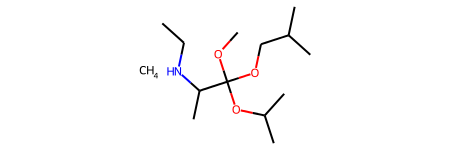

In [597]:
PPO_kwargs = {'env' : env,
              'batch_size' : 32,
              'timesteps_per_batch' : 1200,
              'clip' : 0.08,
              'a_lr' : 1e-4,
              'c_lr' : 3e-4,
              'n_updates_per_iteration' : 6,
              'max_timesteps_per_episode' : 40,
              'gamma' : .95,
              'actor' : svtr.svw.policy,
             'writer': SummaryWriter(f'./tb_logs/3/3_logs')}
ppo_test = PPO_MAIN(**PPO_kwargs)
ppo_test.inference()


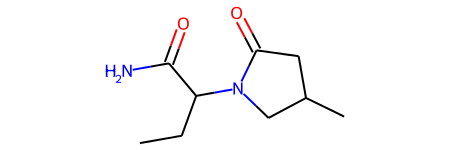

In [580]:
Chem.MolFromSmiles('CCC(C(N)=O)N1CC(C)CC1=O')

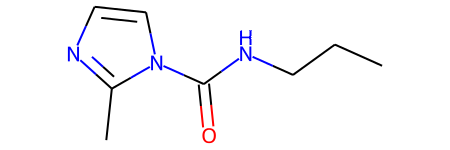

In [497]:
Chem.MolFromSmiles('CCCNC(=O)n1ccnc1C')

------attempting to add 1 bond between last atom added and atom 1------ 



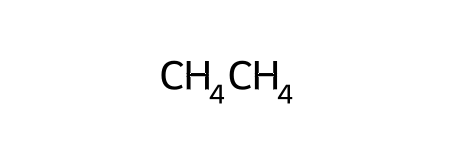

In [533]:
env.assignMol(Chem.MolFromSmiles('C.C'))
env.step(19,verbose=True)
env.StateSpace

In [265]:
chem_env_kwargs = {'max_nodes' : 12, 
                   'num_atom_types' : 17, 
                   'num_node_feats' : 54,
                   'num_edge_types' : 3, 
                   'bond_padding' : 12, 
                   'mol_featurizer': mol_to_graph_full, 
                   'RewardModule' : rewards_list, 
                   'writer' : SummaryWriter(f'./tb_logs/3/3_logs'),
                   'num_chunks': 1}

In [256]:
%run ChemEnv.ipynb

In [411]:
env = ChemEnv(**chem_env_kwargs)

In [235]:
env.assignMol(Chem.MolFromSmiles('CCC.N'))

------adding C atom------ 



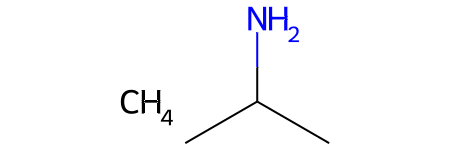

In [239]:
env.step(2, verbose=True)
env.StateSpace

In [267]:
ppo_test = PPO_MAIN(**PPO_kwargs)

correcto


In [268]:
svtr.PPO.actor = svtr.policy

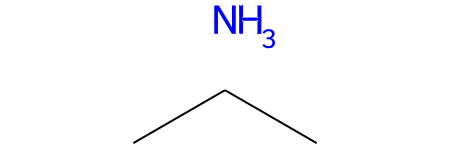

In [269]:
Chem.MolFromSmiles('CCC.N')

In [270]:
ppo_test.inference(True)

C.c1ccc2ncccc2c1
[29]


AttributeError: 'list' object has no attribute 'GiveReward'

In [115]:
torch.save({
            'model_state_dict': svtr.policy.state_dict(),
            'optimizer_state_dict': svtr.svw.optim.state_dict()
            }, './test_1/ah')

FileNotFoundError: [Errno 2] No such file or directory: './test_1/ah'

In [ ]:
svtr.policy.state_dict()
model = Spin2(54,300,17)
model.load_state_dict(svtr.policy.state_dict())

In [ ]:
%run ChemEnv.ipynb
svtr = SupervisedToReinforcement('test',rewards_list,chem_env_kwargs,PPO_kwargs)
env = svtr.ChemEnv

In [ ]:
svtr.PPO.inference()

In [128]:
torch.save(svtr.PPO.actor.state_dict(), './model')

In [ ]:
env = svtr.ChemEnv
env.reset()
env.step(14)
env.step(17)
env.step(14)
env.StateSpace

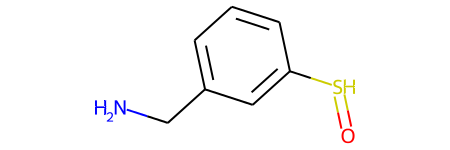

In [66]:
(Chem.MolFromSmiles('NCc1cccc([SH]=O)c1', sanitize = True))


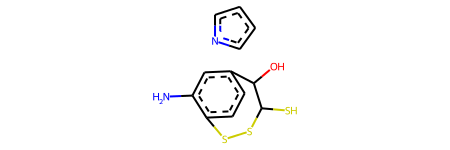

In [980]:
Chem.MolFromSmiles('Nc1cc2ccc1SSC(S)C2O.c1ccnc1', sanitize = False)

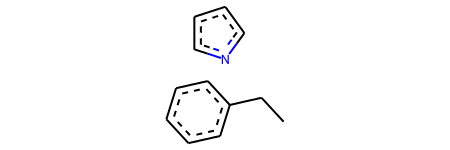

In [962]:


env.reset()
#env.StateSpace = Chem.RWMol(Chem.MolFromSmiles('Nc1cc2ccc1SSC(S)C2O.c1ccnc1', sanitize = False))
#env.step(16)

#env.addEdge(1,0)

env.addBenzine()
env.addEdge(1,0)
env.StateSpace
env.addPyrrole()
env.addEdge(1,11) 
# env.StateSpace.RemoveAtom(17)
# env.StateSpace.RemoveAtom(16)
# env.StateSpace.RemoveAtom(15)
# env.StateSpace.RemoveAtom(14)
# env.StateSpace.RemoveAtom(13)
#Chem.SanitizeMol(env.StateSpace)
env.StateSpace

In [822]:
for atom in env.StateSpace.GetAtoms():
    print(atom.GetDegree(),atom.GetSymbol(),atom.GetIsAromatic())

1 C False
1 C False
2 C True
2 C True
2 C True
2 C True
2 N True


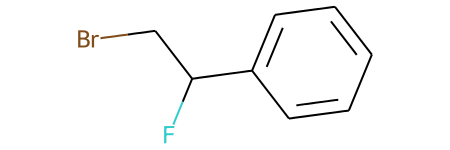

In [731]:
t_mol = Chem.RWMol(Chem.MolFromSmiles('FC(CBr)c1ccccc1',sanitize = True))
t_mol

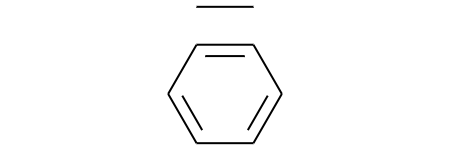

In [737]:
env.reset()
env.addBenzine()
env.addEdge(2,0)
env.StateSpace

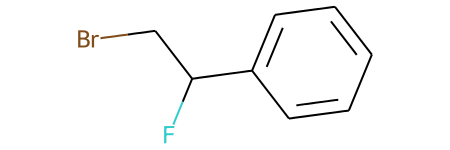

In [735]:
t_mol = Chem.RWMol(Chem.MolFromSmiles('FC(CBr)c1ccccc1',sanitize = True))
env = svtr.ChemEnv
env.reset()
env.StateSpace = t_mol
# env.StateSpace
env.addEdge(2,7)
env.StateSpace

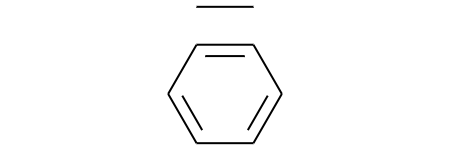

In [651]:
env = svtr.ChemEnv
env.reset()
# env.addPyrrole()
env.addBenzine()
env.addEdge(1,2)
# env.addNode('C')
# env.addEdge(2,4)
#env.addNode('C')
#env.addEdge(1,3)
env.StateSpace

In [609]:
mol2 = SanitizeNoKEKU(mol2)

In [610]:
mol2

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

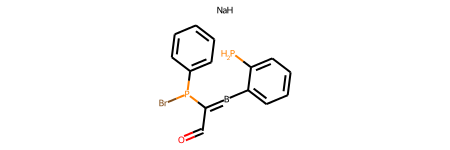

In [625]:

mol2 = Chem.RWMol(Chem.MolFromSmiles('O=CC(=Bc1ccccc1P)P(Br)c1ccccc1.[NaH]', sanitize = True))
mol1 = Chem.RWMol(Chem.MolFromSmiles('CC.c1ccnc1', sanitize = False))
mol2.UpdatePropertyCache()
#mol2.AddAtom(Chem.Atom('C'))
#mol2.AddBond(0,5,Chem.BondType.SINGLE)
# print(mol2.NeedsUpdatePropertyCache())
# mol2.UpdatePropertyCache()
Chem.SanitizeMol(mol2)
mol1.AddBond(0,5,Chem.BondType.SINGLE)
Chem.SanitizeMol(mol1)
mol2

In [469]:
for atom in mol2.GetAtoms():
    print(atom.GetSymbol(),atom.GetImplicitValence())

N 0
C 1
C 1
C 1
C 1


In [390]:
SanitizeNoKEKU(mol2)
cycles = list(mol2.GetRingInfo().AtomRings())
for cycle in cycles:
    for atom_idx in cycle:
        bonds = mol2.GetAtomWithIdx(atom_idx).GetBonds()
        for bond_x in bonds:
            if bond_x.GetBondType() == Chem.BondType.DOUBLE:
                print("fraraf")

fraraf
fraraf
fraraf


In [343]:
for atom in mol2.GetAtoms():
    atom.UpdatePropertyCache()
    print(atom.GetExplicitValence())

1
4
2
4
3
3
4
4
1
3
4
1


In [303]:
for bond in atom.GetBonds():
    print(bond.GetBondType())

AROMATIC
AROMATIC


In [271]:
#env.reset()
env.addPyrrole()

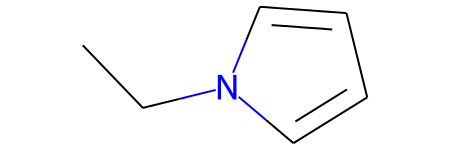

In [274]:
env.StateSpace

In [273]:
env.step(17)

17
frafraprafp
CCn1cccc1


((Graph(num_nodes=7, num_edges=21,
        ndata_schemes={'atomic': Scheme(shape=(54,), dtype=torch.float32)}
        edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)}),
  tensor([[0.]]),
  tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
           0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
           0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1103]],
         device='cuda:0')),
 0.1,
 False,
 {'model_reward': 0, 'property_reward': 0, 'step_reward': 0.1})

In [185]:
mol = Chem.MolFromSmiles('n1cccc1', sanitize = False)
mol.UpdatePropertyCache()
for bond in mol.GetBonds():
    print(bond.GetBondType())

AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC


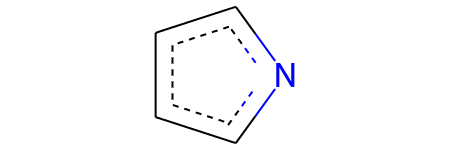

In [186]:
mol

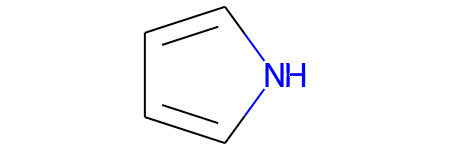

In [175]:
Chem.MolFromSmiles('[nH]1cccc1')

In [161]:
def SanitizeNoKEKU(mol):
    s_dict = {'SANITIZE_ADJUSTHS': Chem.rdmolops.SanitizeFlags.SANITIZE_ADJUSTHS,
    'SANITIZE_ALL': Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, 
    'SANITIZE_CLEANUP': Chem.rdmolops.SanitizeFlags.SANITIZE_CLEANUP, 
    'SANITIZE_CLEANUPCHIRALITY': Chem.rdmolops.SanitizeFlags.SANITIZE_CLEANUPCHIRALITY, 
    'SANITIZE_FINDRADICALS': Chem.rdmolops.SanitizeFlags.SANITIZE_FINDRADICALS, 
    'SANITIZE_KEKULIZE': Chem.rdmolops.SanitizeFlags.SANITIZE_KEKULIZE, 
    'SANITIZE_NONE': Chem.rdmolops.SanitizeFlags.SANITIZE_NONE, 
    'SANITIZE_PROPERTIES': Chem.rdmolops.SanitizeFlags.SANITIZE_PROPERTIES, 
    'SANITIZE_SETAROMATICITY': Chem.rdmolops.SanitizeFlags.SANITIZE_SETAROMATICITY, 
    'SANITIZE_SETCONJUGATION': Chem.rdmolops.SanitizeFlags.SANITIZE_SETCONJUGATION, 
    'SANITIZE_SETHYBRIDIZATION': Chem.rdmolops.SanitizeFlags.SANITIZE_SETHYBRIDIZATION, 
    'SANITIZE_SYMMRINGS': Chem.rdmolops.SanitizeFlags.SANITIZE_SYMMRINGS}
    
    #mol = Chem.SanitizeMol(mol,s_dict['SANITIZE_KEKULIZE'])
    mol = Chem.SanitizeMol(mol, s_dict['SANITIZE_ADJUSTHS'] | s_dict['SANITIZE_SETAROMATICITY'] | 
                           s_dict['SANITIZE_CLEANUP'] | s_dict['SANITIZE_CLEANUPCHIRALITY'] | 
                           s_dict['SANITIZE_FINDRADICALS'] | s_dict['SANITIZE_NONE'] | 
                           s_dict['SANITIZE_PROPERTIES'] | s_dict['SANITIZE_SETCONJUGATION'] | 
                           s_dict['SANITIZE_SETHYBRIDIZATION'] | s_dict['SANITIZE_SYMMRINGS'] 
                          )
    return mol

In [143]:
True | False

True

SANITIZE_NONE
5


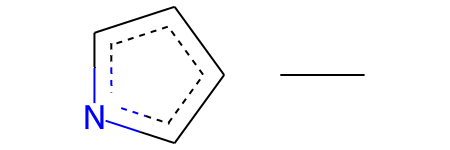

In [162]:
mol = Chem.RWMol(Chem.MolFromSmiles('CC.c1ccnc1', sanitize = False))
#mol.AddBond(8,mol.GetNumAtoms()-1,Chem.BondType.SINGLE)
print(SanitizeNoKEKU(mol))
print(mol.GetAromaticAtoms().__len__())
mol

1


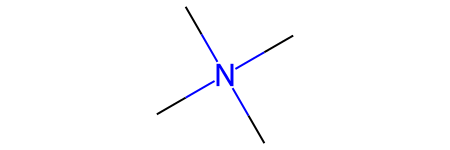

In [164]:
from rdkit import Chem
m = Chem.MolFromSmiles('CN(C)(C)C', sanitize=False)
problems = Chem.DetectChemistryProblems(m)
print(len(problems))
m

In [165]:
SanitizeNoKEKU(m)

AtomValenceException: Explicit valence for atom # 1 N, 4, is greater than permitted

In [131]:
Chem.SanitizeFlags.SANITIZE_ADJUSTHS

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ADJUSTHS

In [118]:
print(problems[0].GetType())
#print(problems[0].GetAtomIdx())
print(problems[0].Message())

KekulizeException
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6



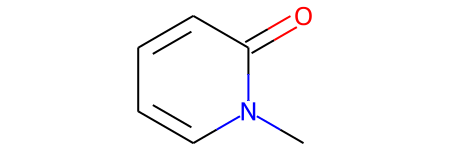

In [119]:
Chem.MolFromSmiles('CN1C=CC=CC1=O')

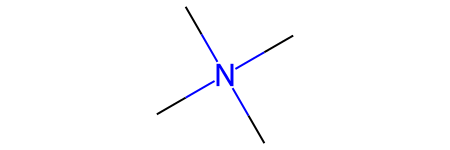

In [114]:
Chem.MolFromSmiles('CN(C)(C)C', sanitize=False)

In [ ]:
# wants: a single class for pretraining and rl training
#     also want a singler logger for everything
#     also should put in cross validation for the supervised portion
#     means a logger instance in the init method

class SupervisedToReinforcement():
    def __init__(self, PPO_env, PPO_Train_Steps, policy_model,rewards, run_title):
        
        
        self.writer = SummaryWriter('./run_title')
        self.reward_module =  FinalRewardModule(sef.writer,rewards)
        
        
        self.PPO_env = PPO_env
        self.PPO_Train_Steps = PPO_Train_Steps        
        self.SV_trainer = Supervised_trainer(policy_model)
       
    
        self.SV_trainer.writer = self.writer
        self.PPO_env.env.RewardModule = self.reward_module
        self.PPO_env.actor = self.policy_model
    
    def Train():
        sv_trainer.Train(20,16, 1,24)
        self.PPO_env.learn(self.PPO_Train_Steps)
        

In [1]:
class AdversarialTraining():
    def __init__(self, PPO_agent,Disc, epochs, G_steps,
                 D_steps, K, G_pretrain_steps, D_train_size,
                 D_batch_size,pre_train_env, smiles_values):
        
        self.PPO_agent = PPO_agent
        self.Disc = Disc
        
        self.epochs = epochs
        self.G_steps = G_steps
        self.D_steps = D_steps
        self.K = K 
        
        self.pre_train_env = pre_train_env
        
        self.D_batch_size = D_batch_size 
        self.D_train_size = D_train_size
        self.smiles_values = smiles_values
        
    def mini_batch_reward_train(self, batch_size, num_batch):
        for j in range(num_batch):
            graphs = self.PPO_agent.generate_graphs(batch_size)
            for model in self.reward_models:
                model.TrainOnBatch(graphs)
            
    def _preTrain(self):
        
        
        env,batch_size,timesteps_per_batch,clip,a_lr,c_lr,
        n_updates_per_iteration,max_timesteps_per_episode,gamma

        
        t_dict = vars(self.PPO_agent)
        PPO_agent_pre = PPO_MAIN(t_dict['env'],t_dict['batch_size'],t_dict['timesteps_per_batch'],
                                 t_dict['clip'],t_dict['a_lr'], t_dict['c_lr'],
                                 t_dict['n_updates_per_iteration'],t_dict['max_timesteps_per_episode'],
                                 t_dict['gamma'])
        
        
        
        PPO_agent_pre.learn(G_pretrain_steps)
        self.PPO_agent.assignActor(PPO_agent_pre.actor)
        
        
        
    def pull_real_samples(self, g_number):
        graphs = smiles_to_graph([self.smiles_values[random.randint(0,len(self.smiles_values))] for _ in range(g_number)])
        print(len(graphs), "graph len")
            
        return graphs
    def i_hate_python(self):
        a = self.PPO_agent.generate_graphs(10)
    def train(self, epochs):
        self._preTrain()
        for epoch in range(epochs):
            print('G_train')
            self.PPO_agent.learn(G_steps) 
            
            print('D_train')
            for d_step in range(self.D_steps):
                
                x_fake = self.PPO_agent.generate_graphs(self.D_steps)
                x_real = self.pull_real_samples(self.D_train_size)
                for k_step in range(self.K):
                    slices = list(range(0,self.D_train_size,self.D_batch_size)) + [self.D_train_size]
                    for idx in range(1,len(slices)):
                        slice_= slice(slices[idx-1],slices[idx])
                        print(slice_)
                        
                        
                        x_fake_batch = x_fake[slice_]
                        if x_fake_batch != []:
                            Y_fake_batch = torch.zeros(len(x_fake_batch),1)


                            x_real_batch = x_real[slice_]
                            Y_real_batch = torch.ones(len(x_real_batch),1)


                            self.Disc.train(x_fake_batch, Y_fake_batch)
                            self.Disc.train(x_real_batch,Y_real_batch)
                        
                
                
            
                
        